<a href="https://colab.research.google.com/github/Arashkhajooei/CRM-Task/blob/main/CEM_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preprocessing**

**Load the Dataset**
- Load the dataset from a CSV file.
- Use `encoding="ISO-8859-1"` to avoid character encoding issues.

In [ ]:
# Load the dataset
file_path = "crm/combined_dataset.csv"  # Update the file path if needed
df = pd.read_csv(file_path, encoding="ISO-8859-1")

**Replace Missing Descriptions for StockCodes with UnitPrice 0**
- Identify valid **descriptions** for each `StockCode` where `UnitPrice > 0`.
- If a **StockCode** has `UnitPrice == 0`, replace its description with the most common description for that stock.
- If no valid description exists, keep the original.

In [ ]:
# Get valid descriptions for StockCodes with UnitPrice > 0
valid_descriptions = df[df["UnitPrice"] > 0].groupby("StockCode")["Description"].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
).to_dict()

# Keep the original descriptions before modifying
df["OldDescription"] = df["Description"]

# Replace descriptions for StockCodes with UnitPrice 0
df.loc[df["UnitPrice"] == 0, "Description"] = df.loc[df["UnitPrice"] == 0, "StockCode"].map(valid_descriptions)

# If no valid description is found, keep the original description
df["Description"] = df["Description"].fillna(df["OldDescription"])

**Replace UnitPrice 0 with Correct Values**
- Find the **most common (mode) UnitPrice** for each `StockCode` where `UnitPrice > 0`.
- Replace `UnitPrice == 0` with the correct price if available.
- If no valid price is found, keep it as **0**.

In [ ]:
# Get valid UnitPrice for each StockCode
valid_prices = df[df["UnitPrice"] > 0].groupby("StockCode")["UnitPrice"].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
).to_dict()

# Replace UnitPrice 0 with correct values if available, otherwise keep it as 0
df.loc[df["UnitPrice"] == 0, "UnitPrice"] = df.loc[df["UnitPrice"] == 0, "StockCode"].map(valid_prices).fillna(0)

**Add a Status Column (Cancelled or Successful)**
- Transactions with `InvoiceNo` starting with **'C'** are marked as **"Cancelled"**.
- All other transactions are marked as **"Successful"**.

In [ ]:
df["Status"] = df["InvoiceNo"].apply(lambda x: "Cancelled" if str(x).startswith("C") else "Successful")
df = df.drop_duplicates()

**Reorder Columns for Better Readability**
- Rearrange columns to a logical order.
- Save the cleaned dataset to a new CSV file.

In [ ]:
column_order = ["InvoiceNo", "StockCode", "Description", "OldDescription", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country", "Status"]
df = df[column_order]

# Save the cleaned dataset
df.to_csv("crm/df.csv", index=False)

print("Cleaned dataset saved successfully!")

In [58]:
# Load the dataset
file_path = "/content/df.csv"
df = pd.read_csv(file_path)

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# **Cross-Selling Analysis**


**Import Required Libraries**
- `pandas` for data manipulation
- `matplotlib` and `seaborn` for visualizing cross-selling analysis

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# Filter successful transactions with valid CustomerID
df_cleaned = df[(df['Status'] == 'Successful') & df['CustomerID'].notnull()]

Identify Top 20 Best-Selling Products**
- Group data by **product description**.
- Sum the **quantity sold** per product.
- Select the **top 20 best-selling products**.
- Save results to a CSV file for future reference.


In [64]:
# Identify top 20 best-selling products based on quantity sold
top_products = df_cleaned.groupby('Description')['Quantity'].sum().nlargest(20)

# Save the results to a CSV file
top_products.to_csv("top_20_cross_selling_analysis.csv", header=True)

# Display the top 20 best-selling products
print(top_products)


Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54319
JUMBO BAG RED RETROSPOT               46078
WHITE HANGING HEART T-LIGHT HOLDER    36706
ASSORTED COLOUR BIRD ORNAMENT         35263
PACK OF 72 RETROSPOT CAKE CASES       33670
POPCORN HOLDER                        30919
RABBIT NIGHT LIGHT                    27153
MINI PAINT SET VINTAGE                26076
PACK OF 12 LONDON TISSUES             25329
PACK OF 60 PINK PAISLEY CAKE CASES    24230
BROCADE RING PURSE                    22927
VICTORIAN GLASS HANGING T-LIGHT       22404
ASSORTED COLOURS SILK FAN             21876
RED  HARMONICA IN BOX                 20945
JUMBO BAG PINK POLKADOT               20148
SMALL POPCORN HOLDER                  18241
60 TEATIME FAIRY CAKE CASES           17664
LUNCH BAG RED RETROSPOT               17576
Name: Quantity, dtype: int64


**Create a Pivot Table for Cross-Selling Heatmap**
- Transform data into a **pivot table** where:
  - **Rows (index)** = Antecedent products
  - **Columns** = Consequent products
  - **Values** = Confidence of cross-selling relationships

**Visualize Cross-Selling Analysis with a Heatmap**

- Use a **heatmap** to visualize cross-selling confidence percentages.
- Empty cells (NaN values) are styled with **golden yellow** for better visibility.
- The **color map** represents confidence levels in shades of **green**.

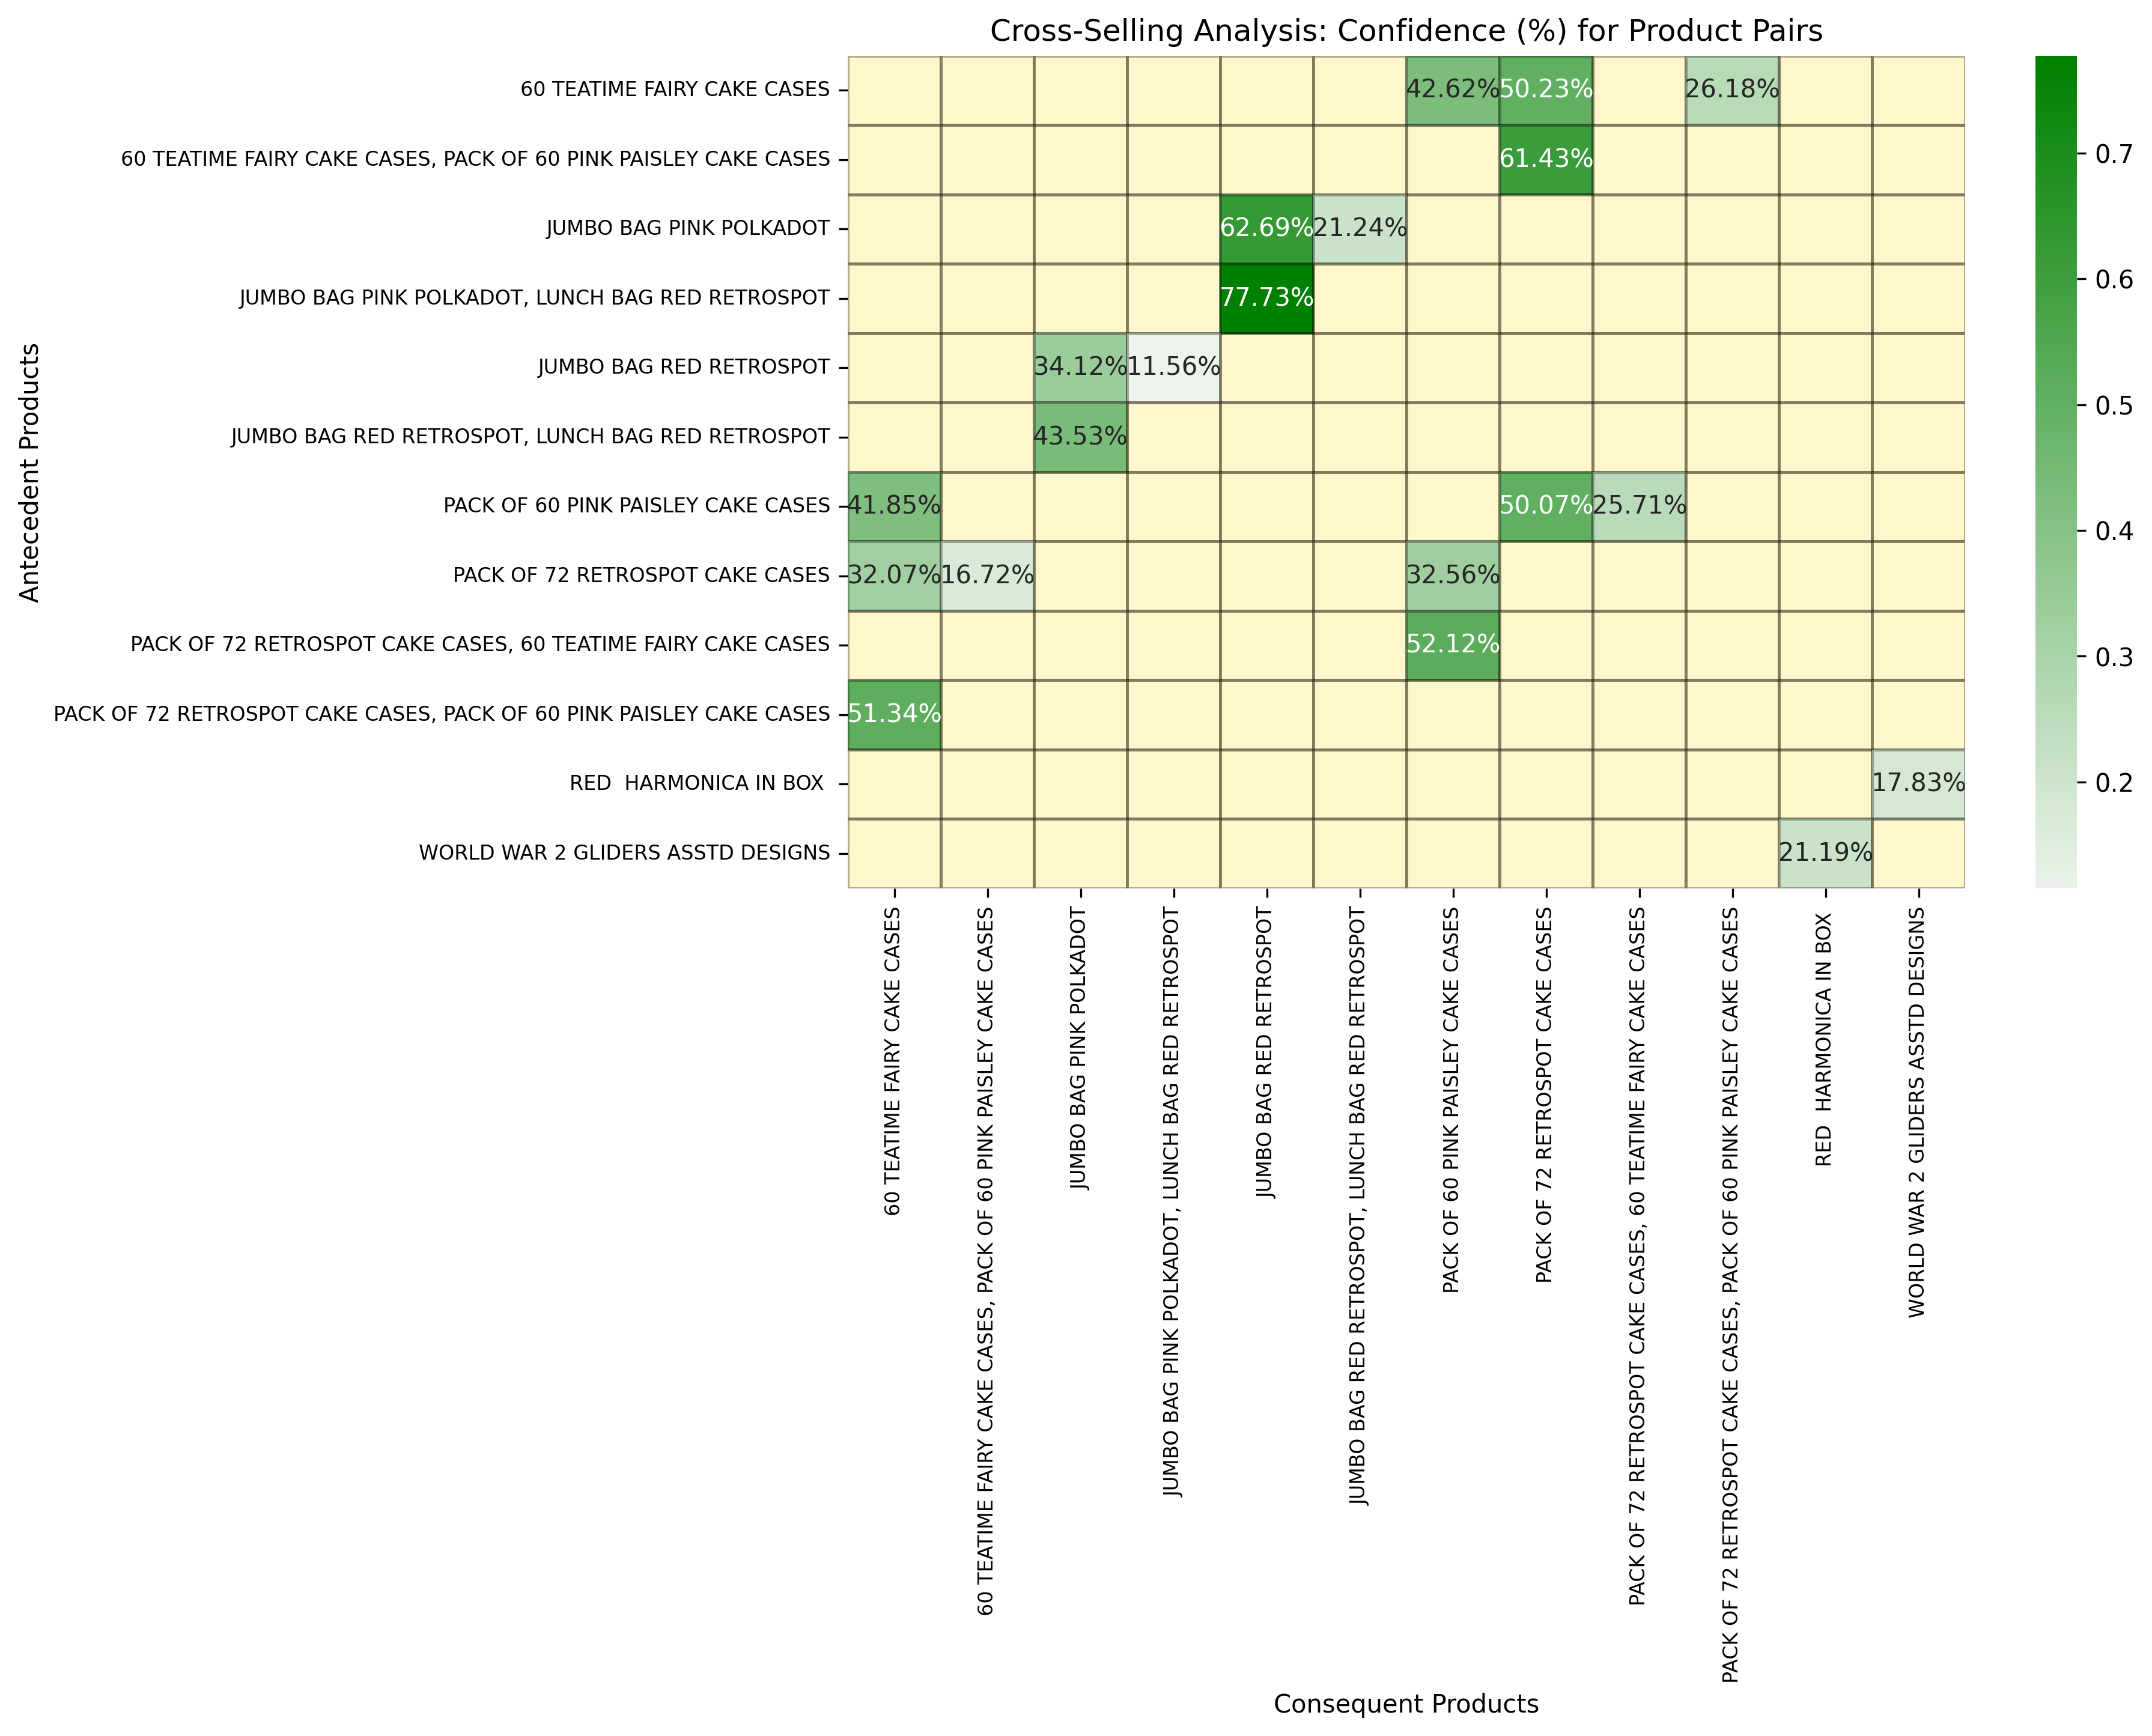

In [66]:
file_path = "/content/top_20_cross_selling_analysis.csv"
df_results = pd.read_csv(file_path)

# Pivot table for heatmap (Confidence values)
pivot_table = df_results.pivot(index="antecedents", columns="consequents", values="confidence")

# Create a mask for NaN values (no association between product pairs)
mask = pivot_table.isna()

# Set up figure size for a compact yet clear visualization
plt.figure(figsize=(10, 6), dpi=300)

# Define a custom colormap with a green gradient and golden yellow for NaNs
cmap = sns.light_palette("green", as_cmap=True)
cmap.set_bad(color="#FFD700", alpha=0.2)
# Plot heatmap with black strokes (opacity 0.3)
sns.heatmap(
    pivot_table,
    annot=True,
    cmap=cmap,
    fmt=".2%",
    linewidths=1.2,
    linecolor=(0, 0, 0, 0.3),  # Black stroke with 30% opacity
    mask=mask
)

# Titles and labels
plt.title("Cross-Selling Analysis: Confidence (%) for Product Pairs", fontsize=12)
plt.xlabel("Consequent Products", fontsize=10)
plt.ylabel("Antecedent Products", fontsize=10)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Show plot
plt.show()

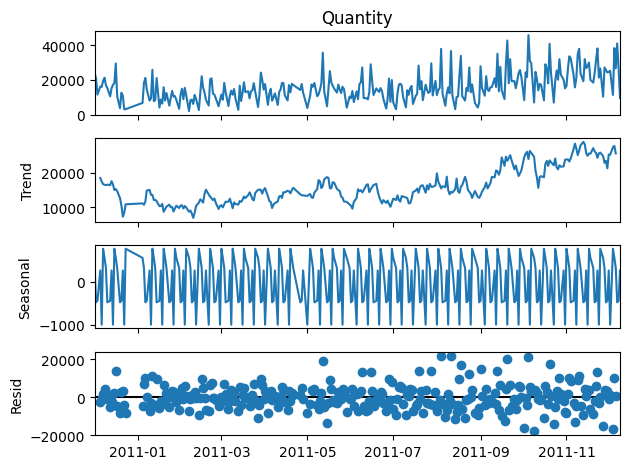

<Figure size 1200x600 with 0 Axes>

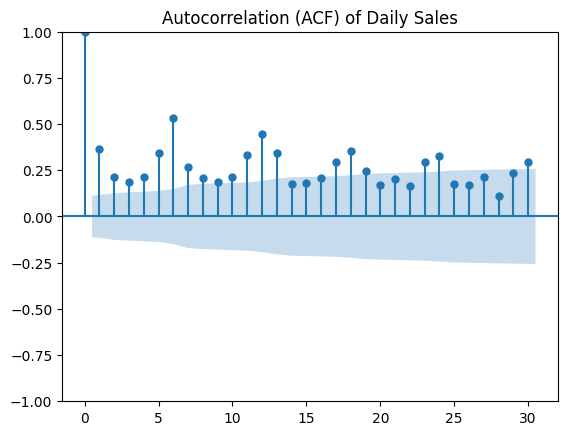

<Figure size 1200x600 with 0 Axes>

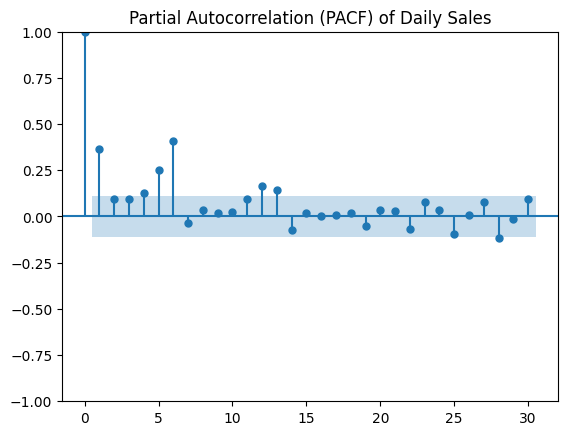

In [61]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Decompose the daily sales data
result = seasonal_decompose(daily_sales, model='additive', period=7)
result.plot()
plt.show()

# Plot Autocorrelation (ACF) and Partial Autocorrelation (PACF)
plt.figure(figsize=(12, 6))
plot_acf(daily_sales, lags=30)
plt.title('Autocorrelation (ACF) of Daily Sales')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(daily_sales, lags=30)
plt.title('Partial Autocorrelation (PACF) of Daily Sales')
plt.show()

In [ ]:
# Extract weekday and hour-related features
df['Weekday'] = df['InvoiceDate'].dt.day_name()  # Weekday name (e.g., Monday, Tuesday)
df['Hour'] = df['InvoiceDate'].dt.hour

# Aggregate sales data by weekday
weekday_sales = df.groupby('Weekday')['Quantity'].sum()

# Reorder the weekdays to appear in the correct order (Monday, Tuesday, etc.)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(weekday_order, fill_value=0)  # Fill missing weekdays with 0


# Aggregate sales data by hour
hourly_sales = df.groupby('Hour')['Quantity'].sum()

# Plot Weekday Sales Distribution
plt.figure(figsize=(10, 5))
plt.bar(weekday_sales.index, weekday_sales.values, color='skyblue')
plt.xlabel("Weekday")
plt.ylabel("Total Quantity Sold")
plt.title("Weekday Sales Distribution")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot Hourly Sales Distribution
plt.figure(figsize=(8, 6), dpi=300)
plt.bar(hourly_sales.index, hourly_sales.values, color='lightgreen')
plt.xlabel("Hour of the Day")
plt.ylabel("Total Quantity Sold")
plt.title("Hourly Sales Distribution")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

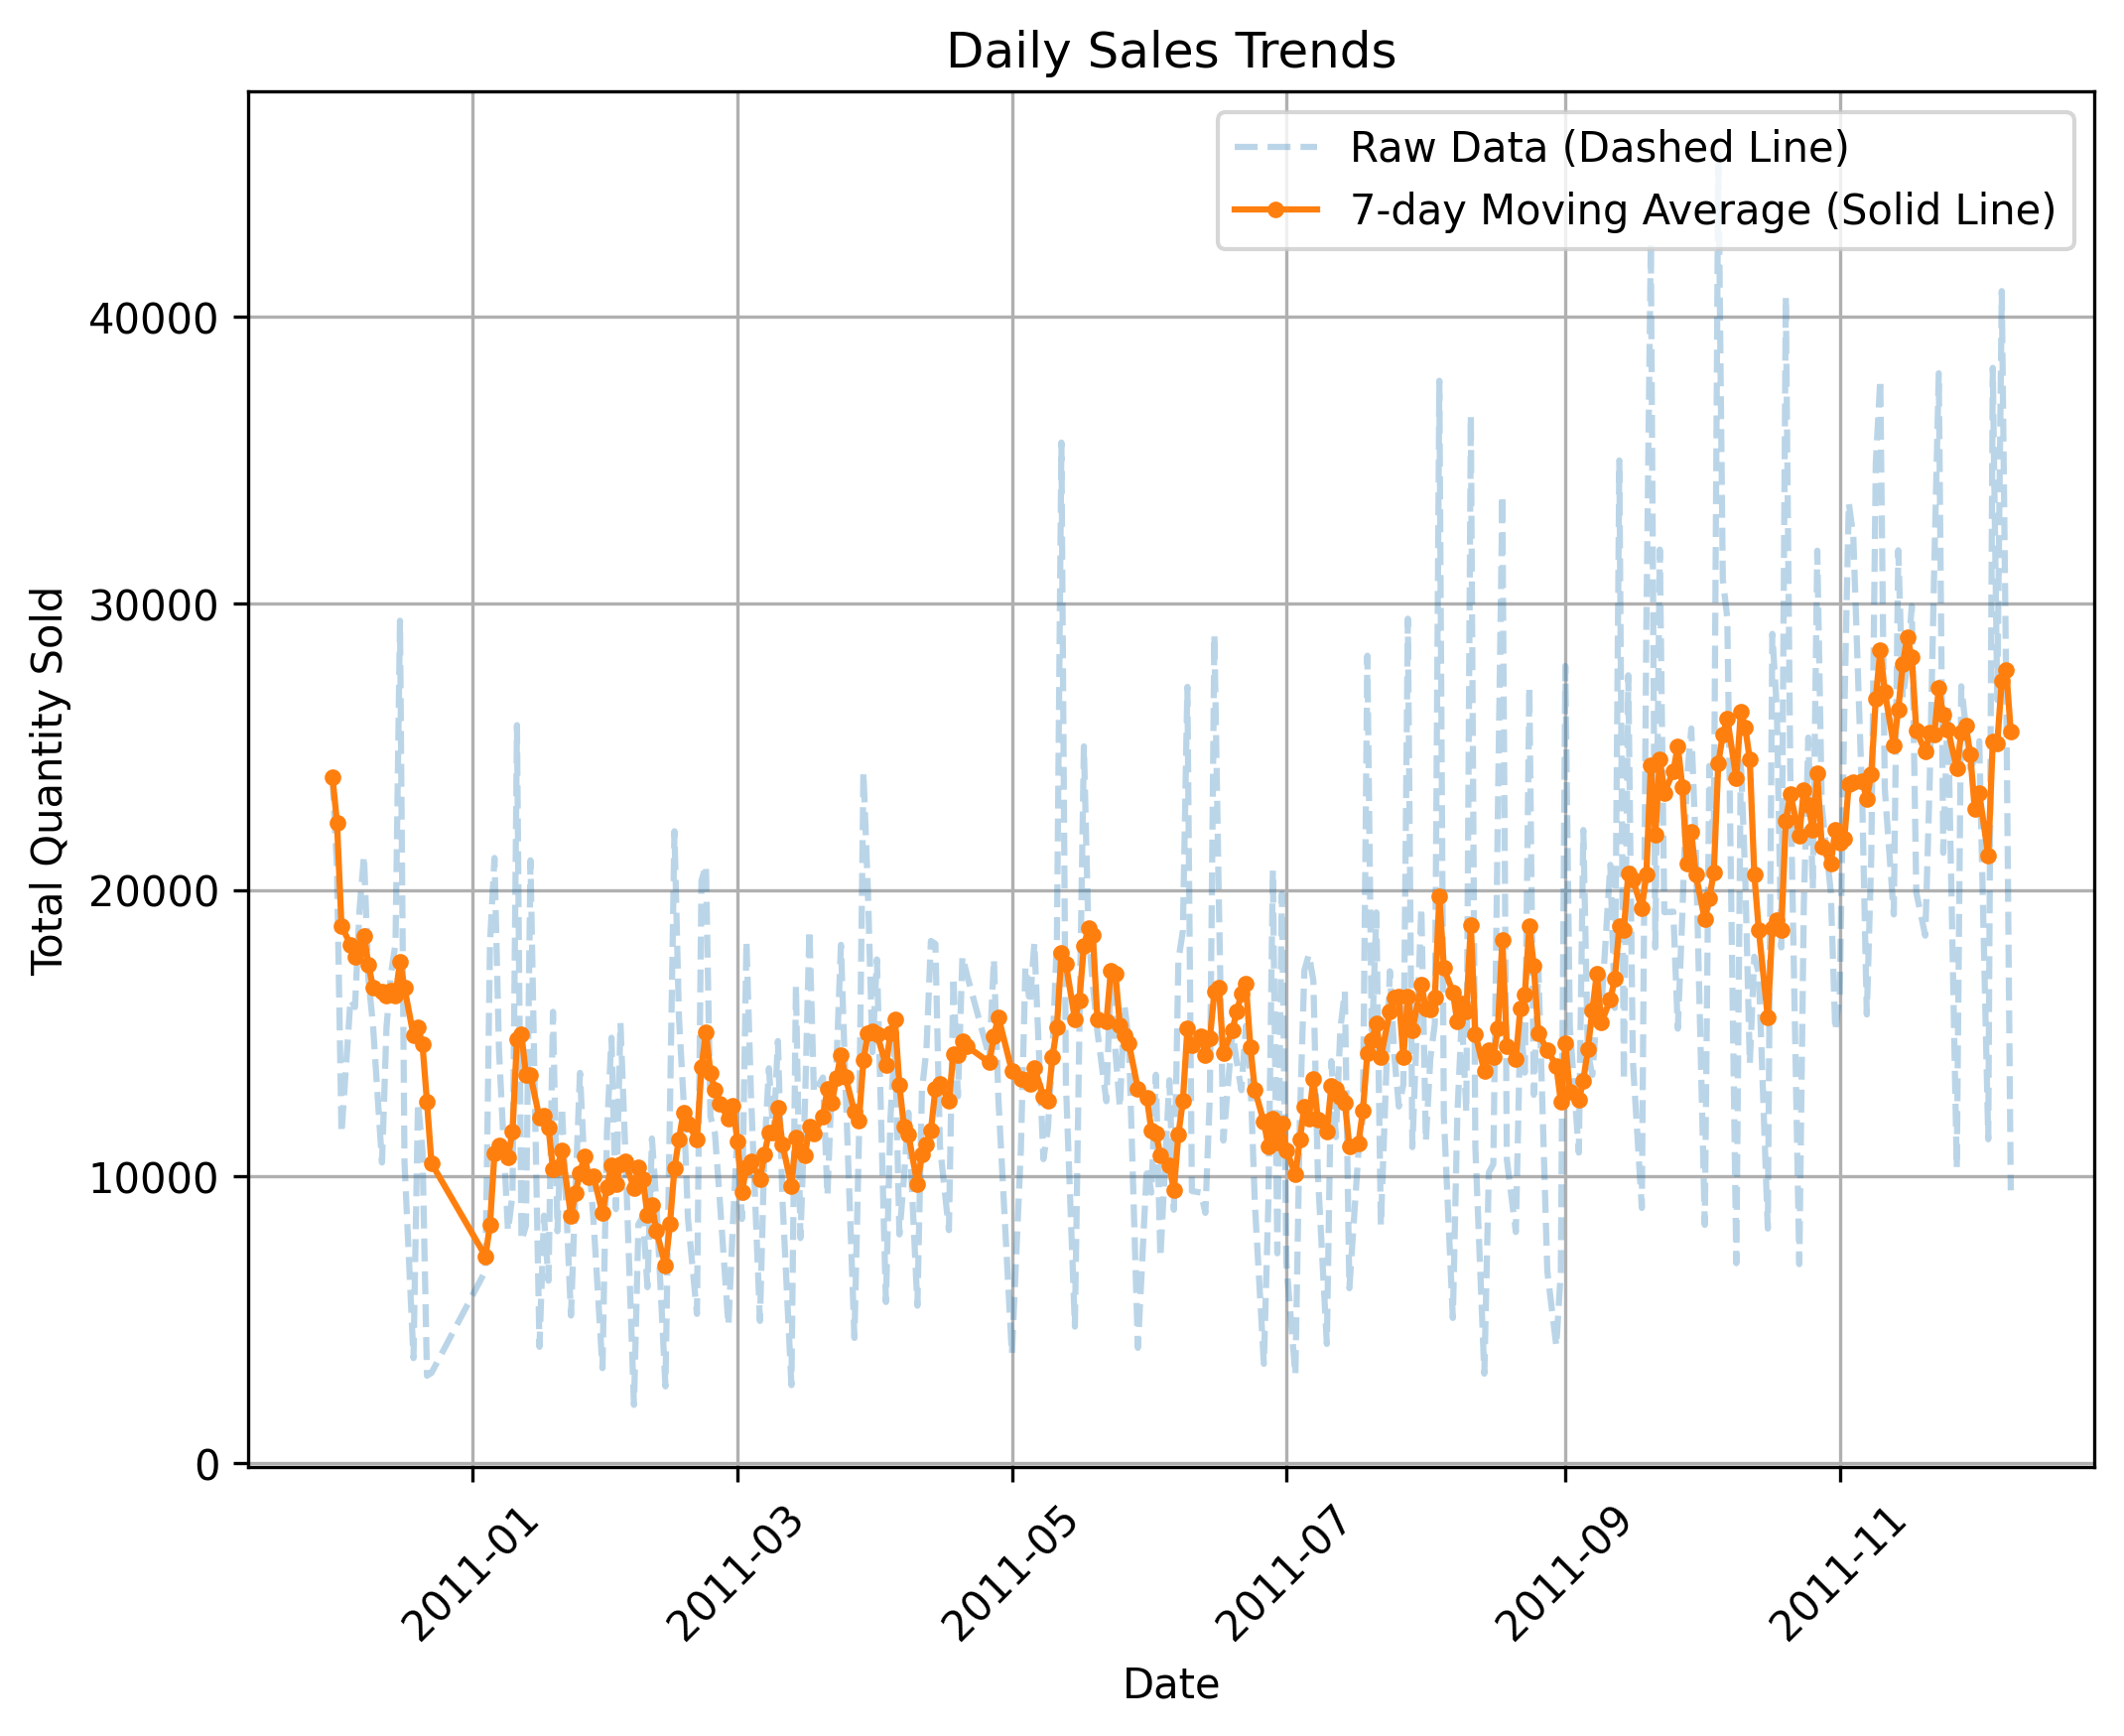

In [56]:
# Extract date-related features
df['Date'] = df['InvoiceDate'].dt.date

# Aggregate sales data daily
daily_sales = df.groupby('Date')['Quantity'].sum()

# Define a moving average function
def moving_average(data, window_size=7):
    return data.rolling(window=window_size, min_periods=1).mean()

# Compute the 7-day moving average
daily_sales_ma = moving_average(daily_sales, window_size=7)

# Plot Daily Sales Trends with 7-day moving average
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(daily_sales.index, daily_sales.values, linestyle='dashed', alpha=0.3, label="Raw Data (Dashed Line)")
plt.plot(daily_sales.index, daily_sales_ma.values, marker='o', markersize=3, linestyle='-', label="7-day Moving Average (Solid Line)")
plt.xlabel("Date")
plt.ylabel("Total Quantity Sold")
plt.title("Daily Sales Trends")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# **Cohort analysis**

**Load the Dataset**
- Read the dataset from a CSV file.
- Convert `InvoiceDate` to datetime format for proper date-based calculations.

In [67]:
file_path = '/content/df.csv'
df = pd.read_csv(file_path)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df = df.dropna(subset=['CustomerID'])

**Extract Year-Month from InvoiceDate for Cohort Grouping**
- Create a new column `InvoiceYearMonth` to store the **year and month** of each transaction.
- Identify each **customer's first purchase month** (`CohortMonth`).

In [45]:
# Extract Year-Month for cohort analysis
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Get the first purchase month for each customer
cohort_data = df.groupby('CustomerID')['InvoiceYearMonth'].min().reset_index()
cohort_data.columns = ['CustomerID', 'CohortMonth']

# Merge cohort data with the original dataset
df = df.merge(cohort_data, on='CustomerID')

**Calculate the Cohort Index (Months Since First Purchase)**
- The **cohort index** represents the number of months since a customer made their first purchase.
- It is computed as the difference between the **current purchase month** and **first purchase month**.

In [46]:
# Create a cohort index (month difference from cohort start)
df['CohortIndex'] = (df['InvoiceYearMonth'].astype(int) - df['CohortMonth'].astype(int))

**Build the Cohort Retention Table**
- Count **unique customers** per cohort per month.
- Convert this to a **retention rate** (percentage of customers retained over time).

In [47]:
# Count unique customers per cohort per month
cohort_pivot = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().unstack(0)

# Convert to percentage (retention rate)
cohort_pivot = cohort_pivot.div(cohort_pivot.iloc[0], axis=1)

**Visualize Customer Retention Using a Heatmap**
- Use a **heatmap** to display the cohort retention rates.
- The retention rate shows how many customers from each cohort remain active over time.

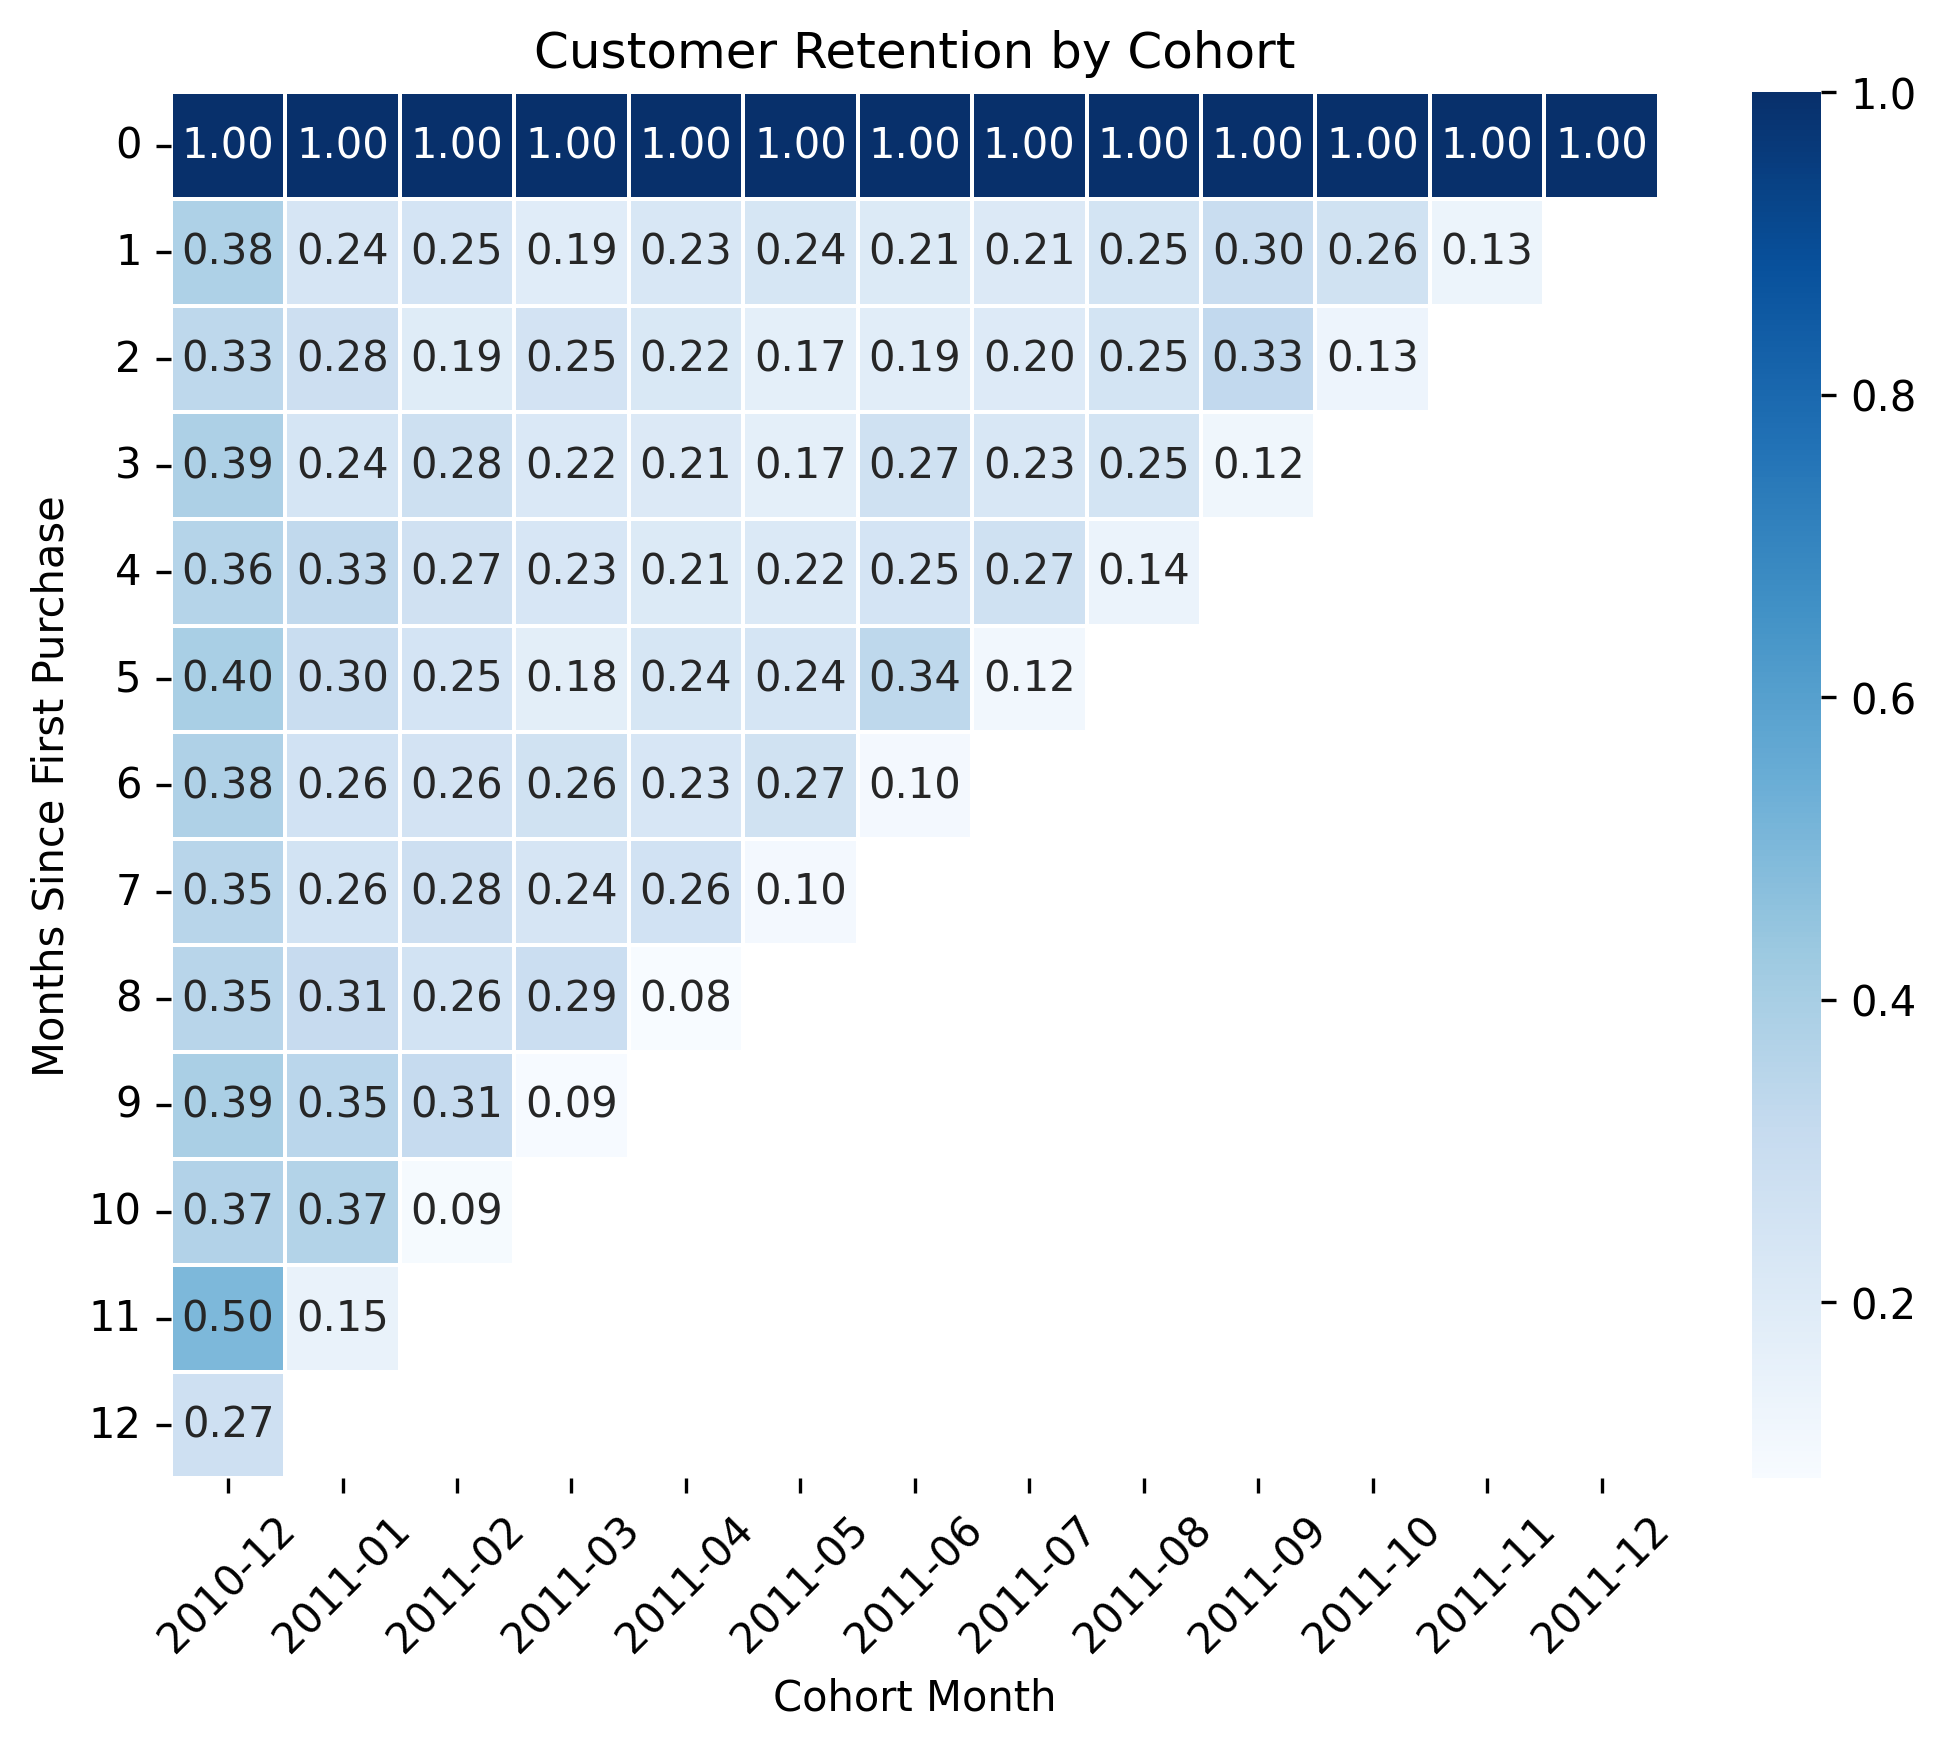

In [54]:
plt.figure(figsize=(8, 6), dpi=300)  # Adjust figure size & increase resolution
sns.heatmap(cohort_pivot, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5)
plt.title("Customer Retention by Cohort", fontsize=12)
plt.xlabel("Cohort Month", fontsize=10)
plt.ylabel("Months Since First Purchase", fontsize=10)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


# **RFM Data Modeling**

**Import Required Libraries**

In [15]:
import pandas as pd
from datetime import timedelta

**Load the Dataset**
- Read the dataset from a CSV file.
- Drop rows where `CustomerID` is missing to ensure valid transactions.
- Convert `CustomerID` to an integer format for consistency.

In [68]:
file_path = "/content/df.csv"
df = pd.read_csv(file_path)

# Drop rows where CustomerID is missing
df = df.dropna(subset=['CustomerID'])

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

**Convert InvoiceDate and Calculate Total Price**
- Convert `InvoiceDate` to a datetime format for date-based calculations.
- Compute **Total Price** (`Monetary Value`) for each transaction.

In [ ]:
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Total Price per transaction (Monetary Value = Quantity * Unit Price)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Display updated dataset
df.head()

**Define the Latest Date and Filter Transactions**
- Identify the **latest purchase date** in the dataset.
- Set a **cutoff date** (latest date - 365 days) to analyze only the last year's data.

In [ ]:
# Determine the most recent purchase date
latest_date = df['InvoiceDate'].max()

# Set cutoff date for the last 1-year period
cutoff_date = latest_date - timedelta(days=365)

# Filter dataset to include only transactions within the last 1 year
df_filtered = df[df['InvoiceDate'] >= cutoff_date]

# Display the latest and cutoff dates
print(f"Latest Date: {latest_date}")
print(f"Cutoff Date: {cutoff_date}")

# Display filtered dataset
df_filtered.head()


**Compute RFM Metrics**
- Calculate **Recency** (days since last purchase).
- Calculate **Frequency** (total number of purchases).
- Calculate **Monetary** (total amount spent).

In [ ]:
rfm_filtered = df_filtered.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency (number of transactions)
    'TotalPrice': 'sum'  # Monetary (total spending)
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Display RFM metrics
rfm_filtered.head()

**Assign RFM Scores Based on Quartiles**
- **Recency**: More recent customers get a **higher score** (4 = most recent, 1 = least recent).
- **Frequency**: Frequent buyers get a **higher score** (4 = most frequent, 1 = least frequent).
- **Monetary**: Higher spenders get a **higher score** (4 = highest spenders, 1 = lowest spenders).

In [ ]:
# Assign quartile-based scores
rfm_filtered['R_Score'] = pd.qcut(rfm_filtered['Recency'], 4, labels=[4, 3, 2, 1])
rfm_filtered['F_Score'] = pd.qcut(rfm_filtered['Frequency'], 4, labels=[1, 2, 3, 4])
rfm_filtered['M_Score'] = pd.qcut(rfm_filtered['Monetary'], 4, labels=[1, 2, 3, 4])

# Convert scores to integer
rfm_filtered['R_Score'] = rfm_filtered['R_Score'].astype(int)
rfm_filtered['F_Score'] = rfm_filtered['F_Score'].astype(int)
rfm_filtered['M_Score'] = rfm_filtered['M_Score'].astype(int)

# Display updated dataset
rfm_filtered.head()

**Create the RFM Segment**
- Combine **R, F, M scores** into a string to create a **customer segment** (e.g., '444' = best, '111' = least active).

In [ ]:
rfm_filtered['RFM_Segment'] = (
    rfm_filtered['R_Score'].astype(str) +
    rfm_filtered['F_Score'].astype(str) +
    rfm_filtered['M_Score'].astype(str)
)

# Display updated dataset
rfm_filtered.head()

**Compute the RFM Score**
- The **RFM Score** is calculated by summing up **Recency, Frequency, and Monetary** scores.
- A higher score indicates a **more valuable** customer.

In [ ]:
rfm_filtered['RFM_Score'] = rfm_filtered[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Display updated dataset
rfm_filtered.head()

**Summarize RFM Segments**
- Group customers by their **RFM segment** and calculate:
  - **Average Recency**
  - **Average Frequency**
  - **Average Monetary**
  - **Number of customers in each segment**

In [ ]:
rfm_summary_filtered = rfm_filtered.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'count'
}).rename(columns={'RFM_Score': 'Customer_Count'}).sort_values(by='Customer_Count', ascending=False)

# Display segment summary
rfm_summary_filtered.head()

**Save RFM Results to CSV**
- Save **customer-level RFM scores** and **segment summaries** for our analysis.

In [ ]:
rfm_filtered.to_csv("rfm_results_1_year.csv", index=False)
rfm_summary_filtered.to_csv("rfm_segment_summary_1_year.csv", index=False)

print("RFM results saved successfully!")

# **k-means clustering**
In this analysis, I applied the K-Means clustering algorithm to segment customers based on their purchasing patterns. To build meaningful clusters, I performed feature engineering to extract insightful attributes from the transactional dataset. The key features used for clustering include:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

**Load the Dataset and Clean Missing Customer IDs**

In [ ]:
file_path = "/content/df.csv"
df = pd.read_csv(file_path)

# Drop rows where CustomerID is missing
df_cleaned = df.dropna(subset=['CustomerID'])

# Convert CustomerID to integer
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

# Display the first few rows to check data
df_cleaned.head()


**Convert InvoiceDate to DateTime Format**
- Ensure that `InvoiceDate` is in datetime format for accurate date-based calculations.
- Extract daily, weekly, and monthly invoice frequencies per customer.

In [ ]:
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Extract frequency of purchases per customer
df_cleaned['InvoiceDay'] = df_cleaned['InvoiceDate'].dt.date
df_cleaned['InvoiceWeek'] = df_cleaned['InvoiceDate'].dt.to_period('W').astype(str)
df_cleaned['InvoiceMonth'] = df_cleaned['InvoiceDate'].dt.to_period('M').astype(str)

# Display the modified dataset
df_cleaned.head()


**Compute RFM Metrics**
- Calculate **Recency**: Days since the last purchase.
- Calculate **Frequency**: Number of unique purchases (invoices).
- Calculate **Monetary Value**: Total amount spent per customer.

In [ ]:
# Define reference date for recency calculation
reference_date = df_cleaned['InvoiceDate'].max()

# Compute RFM metrics
rfm = df_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'Quantity': lambda x: np.sum(x * df_cleaned.loc[x.index, 'UnitPrice'])  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Quantity': 'Monetary'})

# Display RFM metrics
rfm.head()


**Normalize Recency & Compute Additional Features**
- Normalize **Recency** (scaled between 0 and 1).
- Compute **Spending Per Order** = Monetary Value / Frequency.
- Compute **Time Between Orders** = Recency / Frequency.

In [ ]:
# Normalize Recency
rfm['Recency'] = rfm['Recency'] / rfm['Recency'].max()

# Avoid division by zero for additional metrics
rfm['SpendingPerOrder'] = rfm['Monetary'] / (rfm['Frequency'] + 1e-5)
rfm['TimeBetweenOrders'] = rfm['Recency'] / (rfm['Frequency'] + 1e-5)

# Display the updated dataset
rfm.head()


**Apply MinMax Scaling**
- Scale all features using **MinMaxScaler** to ensure values are on the same scale.
- This helps improve the accuracy of clustering algorithms.

In [69]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(rfm)

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(features_scaled, columns=rfm.columns)

**Finding the Optimal Number of Clusters (K)**
- Compute **Elbow Method** (WCSS - Within Cluster Sum of Squares).
- Compute **Silhouette Score** (measuring cluster cohesion).
- Compute **Davies-Bouldin Score** (lower values indicate better clustering).

In [9]:
wcss = []
silhouette_scores = []
davies_bouldin_scores = []
cluster_range = range(2, 11)  # Testing k from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)

    # Compute evaluation metrics
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(rfm_scaled, kmeans.labels_))


**Visualization of Cluster Metrics**
- Plot **Elbow Method** to determine the best K.
- Plot **Silhouette Score** (higher is better).
- Plot **Davies-Bouldin Score** (lower is better).

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(cluster_range, wcss, marker='o', linestyle='-', label='WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(cluster_range, davies_bouldin_scores, marker='d', linestyle='-', label='Davies-Bouldin Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Score for Optimal K (Lower is Better)')
plt.legend()
plt.show()


**Select the Best K**
- Choose **Optimal K** based on **Silhouette Score** and **Davies-Bouldin Score**.

In [ ]:
optimal_k_silhouette = cluster_range[np.argmax(silhouette_scores)]
optimal_k_davies = cluster_range[np.argmin(davies_bouldin_scores)]

print(f"Optimal K based on Silhouette Score: {optimal_k_silhouette}")
print(f"Optimal K based on Davies-Bouldin Score: {optimal_k_davies}")

# Choose the best K based on analysis
best_k = 4

**Apply K-Means Clustering**
- Cluster customers into **best K clusters**.

In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Display cluster assignments
rfm.head()

**Analyze Customer Segments**
- Summarize cluster characteristics.

In [14]:
cluster_summary = rfm.groupby('Cluster').mean()
print(cluster_summary)

rfm.to_csv("clustered_customers.csv", index=False)
print("Clustered customer data saved as clustered_customers.csv")

          Recency  Frequency    Monetary  SpendingPerOrder  TimeBetweenOrders
Cluster                                                                      
0        0.057190   5.961864  670.234590        118.762026           0.023084
1        0.816733   1.023758   74.295551         72.790953           0.805298
2        0.541661   1.688172  114.258604         69.811466           0.385791
3        0.243317   2.357219  175.552952         78.498381           0.138829
Clustered customer data saved as clustered_customers.csv
